In [3]:
import os
import numpy as np
import pandas as pd

import keras
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, load_img

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2

In [4]:
data_dir = '../input/cassava-leaf-disease-classification/'
train_images_dir = os.path.join(data_dir, 'train_images')
test_images_dir = os.path.join(data_dir, 'test_images')
train_csv = pd.read_csv(os.path.join(data_dir, 'train.csv'), dtype=str)

train_csv, val_csv = train_test_split(train_csv, test_size=0.2)

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=train_images_dir,
    x_col="image_id",
    y_col="label",
    class_mode='categorical',
    target_size=(256, 256),
    batch_size=16
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_csv,
    directory=train_images_dir,
    x_col="image_id", y_col="label", class_mode='categorical',
    target_size=(256, 256),
    batch_size=16
)

Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras import Input, layers, Model, optimizers

In [5]:
def inception_block(input_layer):
    conv1 = Conv2D(64, (1, 1), activation='relu', padding='same')(input_layer)
    # 3x3 conv
    conv3 = Conv2D(32, (1, 1), padding='same', activation='relu')(input_layer)
    conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(32, (1, 1), padding='same', activation='relu')(input_layer)
    conv5 = Conv2D(64, (5, 5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_layer)
    pool = Conv2D(32, (1, 1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    output_layer = layers.merge.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return output_layer

In [6]:
def residual_block(input_layer):
    conv1 = Conv2D(64, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal')(input_layer)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input_layer)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    add_layer = layers.add([conv3, conv1])
    output_layer = layers.Activation('relu')(add_layer)
    return output_layer

In [7]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), padding='same', input_shape=(256, 256, 3), activation='relu'))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Flatten())
# model.add(Dense(10, activation='relu'))
# model.add(Dense(5, activation='softmax'))

# model.compile(keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=["accuracy"])
# history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100)

In [8]:
dropout_rate=0.3
input = Input(shape=(256,256,3))
batch_norm = layers.BatchNormalization()(input)
inception1 = inception_block(batch_norm)
o1 = Dropout(dropout_rate)(inception1)
residual1 = residual_block(o1)
o2 = Dropout(dropout_rate)(residual1)
# inception2 = inception_block(o2)
flatten = Flatten()(o2)
dense1 = Dense(64, activation='relu')(flatten)
output = Dense(5, activation='softmax')(dense1)
model2 = Model(input, output)
model2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 128         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 32) 128         batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
model2.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=1e-4),
                   metrics=['accuracy'])

STEPS_PER_EPOCH = train_generator.n//train_generator.batch_size
# STEPS_PER_EPOCH = 10
epochs=50
history = model2.fit_generator(train_generator, steps_per_epoch=STEPS_PER_EPOCH, epochs=epochs, 
                               validation_data=val_generator, validation_steps=50, shuffle=True, use_multiprocessing=True)
# history = model2.fit(train_generator, steps_per_epoch=STEPS_PER_EPOCH, epochs=epochs, validation_data=val_generator, validation_steps=50)

Epoch 1/50
1069/1069 [==============================] - 603s 564ms/step - loss: 2.4715 - accuracy: 0.6082 - val_loss: 1.5380 - val_accuracy: 0.6075
Epoch 2/50
1069/1069 [==============================] - 547s 512ms/step - loss: 1.5028 - accuracy: 0.6146 - val_loss: 1.4719 - val_accuracy: 0.6062
Epoch 3/50
1069/1069 [==============================] - 552s 517ms/step - loss: 1.4384 - accuracy: 0.6147 - val_loss: 1.4176 - val_accuracy: 0.5987
Epoch 4/50
1069/1069 [==============================] - 553s 517ms/step - loss: 1.3825 - accuracy: 0.6147 - val_loss: 1.3752 - val_accuracy: 0.5875
Epoch 5/50
1069/1069 [==============================] - 551s 515ms/step - loss: 1.3345 - accuracy: 0.6148 - val_loss: 1.2810 - val_accuracy: 0.6513
Epoch 6/50
1069/1069 [==============================] - 542s 507ms/step - loss: 1.2947 - accuracy: 0.6149 - val_loss: 1.2502 - val_accuracy: 0.6425
Epoch 7/50
1069/1069 [==============================] - 543s 508ms/step - loss: 1.2635 - accuracy: 0.6148 - val_

In [14]:
img = load_img(os.path.join(train_images_dir, train_csv.iloc[0][0]))
img = np.asarray(img)

In [7]:
# cv2.extractChannel(img)
# r, g, b = cv2.split(np.asarray(img))

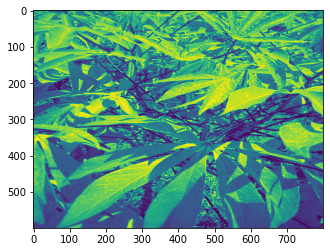

In [38]:
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
plt.imshow(cv2.extractChannel(img, 1))
plt.show()